<a href="https://colab.research.google.com/github/ABCDefghiii/Chronic-Kidney-Disease-Predictor/blob/main/CHRONIC_KIDNEY_DISEASE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np


In [2]:
import joblib

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shruthihaasinikarri","key":"e2093b711b5dfed44d07a89c95c65a18"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!pip install kaggle

In [7]:
!kaggle datasets download -d mansoordaku/ckdisease -p /content/ckdisease --unzip

Dataset URL: https://www.kaggle.com/datasets/mansoordaku/ckdisease
License(s): unknown
  0% 0.00/9.51k [00:00<?, ?B/s]
100% 9.51k/9.51k [00:00<00:00, 31.2MB/s]


In [8]:
# 2. Load Dataset
df = pd.read_csv('/content/ckdisease/kidney_disease.csv')

In [9]:
# Drop ID column if present
if 'id' in df.columns:
    df = df.drop(['id'], axis=1)

Dataset Shape: (400, 25)
Columns: ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']


/tmp/ipython-input-1827931792.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="classification", data=df, palette="Set2")


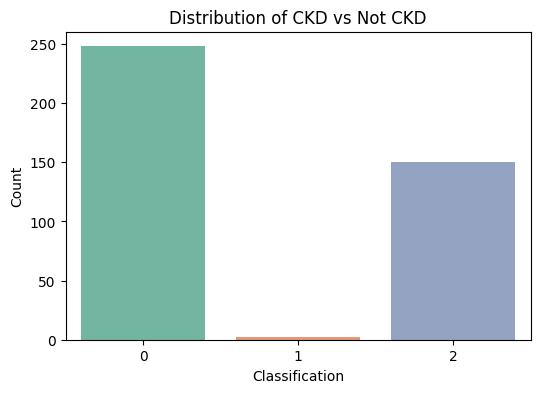

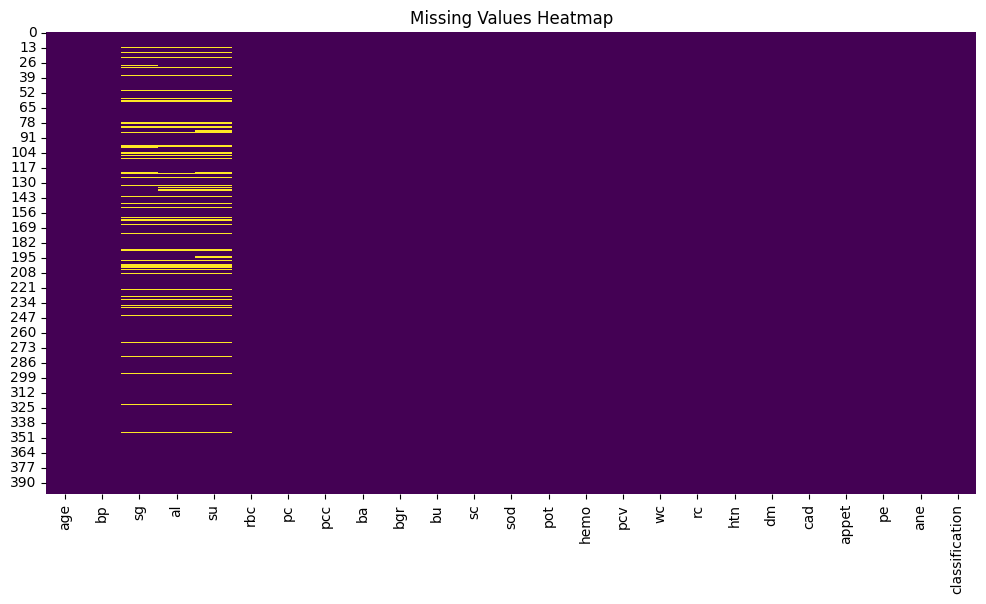

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic info
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Distribution of target variable
plt.figure(figsize=(6,4))
sns.countplot(x="classification", data=df, palette="Set2")
plt.title("Distribution of CKD vs Not CKD")
plt.xlabel("Classification")
plt.ylabel("Count")
plt.show()


# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


In [10]:
# 3. Preprocessing
# Define numeric and categorical columns
num_cols = ['age','bp','bgr','bu','sc','hemo','pcv','sod','pot','wc','rc']
cat_cols = ['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']

In [11]:
# Clean numeric cols
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].replace(r'^\s*\??\s*$', np.nan, regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())

In [12]:
# Clean categorical cols
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].replace(r'^\s*\??\s*$', np.nan, regex=True)
        df[col] = df[col].fillna(df[col].mode()[0])

In [13]:
# Encode categorical variables using LabelEncoder
encoders = {}
for col in cat_cols + ['classification']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

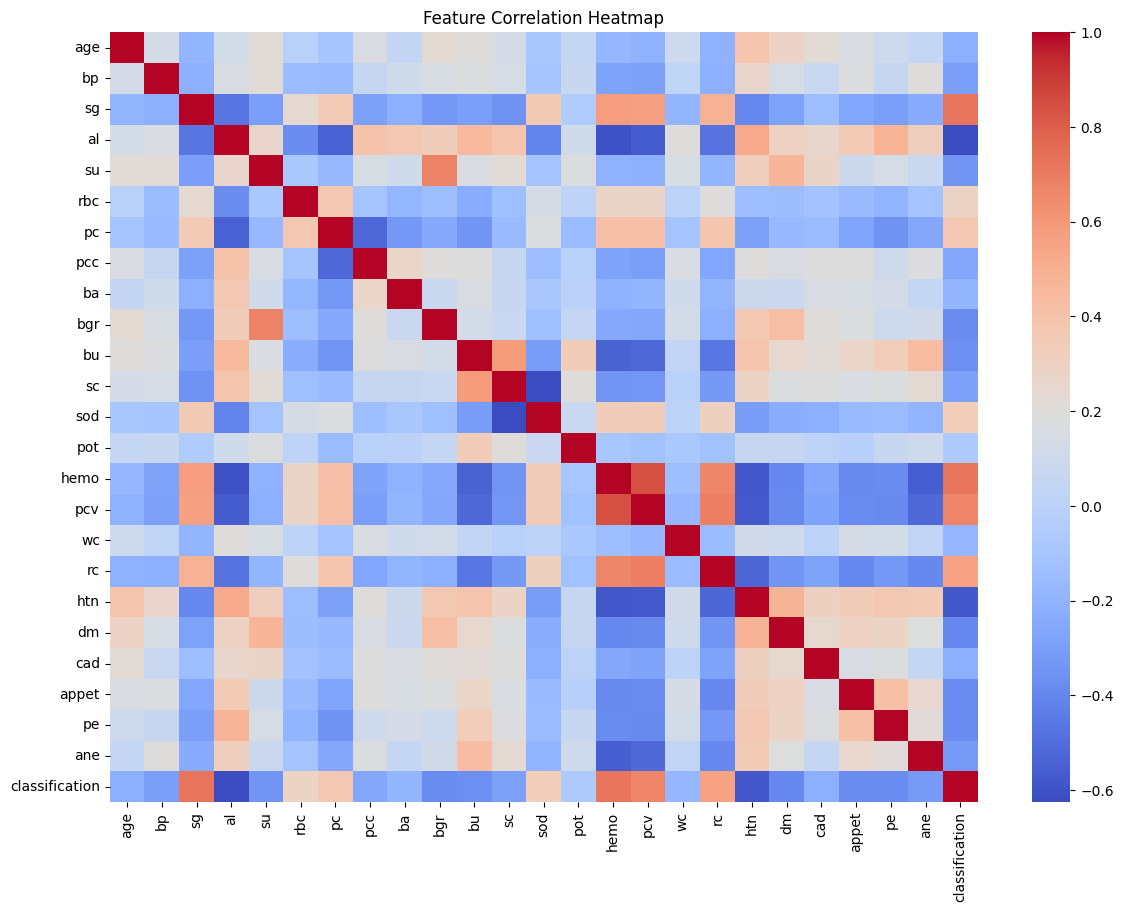

In [22]:
# Correlation heatmap
plt.figure(figsize=(14,10))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [14]:
# 4. Split Data
X = df.drop('classification', axis=1)
y = df['classification']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
# 5. Scale Data
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [16]:
# 6. Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# 7. Evaluate Model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           2       1.00      1.00      1.00        28

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Confusion Matrix:
 [[52  0]
 [ 0 28]]


In [18]:
# 8. Save Model, Scaler, and Encoders
joblib.dump(model, 'ckd_rf_model.pkl')
joblib.dump(scaler, 'ckd_rf_scaler.pkl')
joblib.dump(encoders, 'ckd_label_encoders.pkl')

# User template (one row of training data structure)
X.head(1).to_csv('CKD_user_template.csv', index=False)
print("Template saved as CKD_user_template.csv")

Template saved as CKD_user_template.csv


In [37]:
# 9. Prediction from User CSV
import pandas as pd
import joblib

# Step 1: Load user template CSV
from google.colab import files
uploaded = files.upload()  # Upload CKD_user_template.csv
user_df = pd.read_csv(list(uploaded.keys())[0])

# Step 2: Map categorical/binary columns to numeric
binary_cols = ['htn','dm','cad','appet','pe','ane']
for col in binary_cols:
    user_df[col] = user_df[col].map({'yes':1,'no':0})

cat_cols = ['rbc','pc','pcc','ba']
user_df['rbc'] = user_df['rbc'].map({'normal':1,'abnormal':0})
user_df['pc'] = user_df['pc'].map({'normal':1,'abnormal':0})
user_df['pcc'] = user_df['pcc'].map({'present':1,'notpresent':0})
user_df['ba'] = user_df['ba'].map({'present':1,'notpresent':0})

# Step 3: Ensure numeric columns are float
num_cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'hemo', 'pcv', 'sod', 'pot', 'wc', 'rc']
for col in num_cols:
    user_df[col] = user_df[col].astype(float)

# Step 4: Load trained model & scaler
model = joblib.load('ckd_rf_model.pkl')
scaler = joblib.load('ckd_rf_scaler.pkl')

# Step 5: Align user_df columns with model training columns
training_cols = model.feature_names_in_  # columns used during model training
user_df_aligned = user_df.reindex(columns=training_cols, fill_value=0)

# Step 6: Scale numeric columns used in training
numeric_cols_in_scaler = scaler.feature_names_in_
user_df_aligned[numeric_cols_in_scaler] = scaler.transform(user_df_aligned[numeric_cols_in_scaler])

# Step 7: Make predictions
preds = model.predict(user_df_aligned)
user_df['CKD_Prediction'] = preds
# Map 0/1/2 to user-friendly labels if needed
user_df['CKD_Prediction'] = user_df['CKD_Prediction'].map({0:'No CKD', 1:'CKD', 2:'CKD'})

# Step 8: Show results
print(user_df)


Saving CKD_user_template.csv to CKD_user_template (8).csv
    age     bp     sg  al  su  rbc  pc  pcc  ba    bgr  ...   pcv       wc  \
0  48.0   80.0  1.020   1   0  NaN NaN  NaN NaN  121.0  ...  44.0   7800.0   
1  60.0   90.0  1.015   3   0  NaN NaN  NaN NaN  150.0  ...  36.0   1200.0   
2  35.0   70.0  1.025   0   1  NaN NaN  NaN NaN   98.0  ...  45.0    800.0   
3  72.0  100.0  1.010   4   0  NaN NaN  NaN NaN  200.0  ...  32.0  15000.0   
4  50.0   85.0  1.020   1   1  NaN NaN  NaN NaN  130.0  ...  28.0  12000.0   

    rc  htn  dm  cad  appet  pe  ane  CKD_Prediction  
0  5.2  NaN NaN  NaN    NaN NaN  NaN             CKD  
1  3.8  NaN NaN  NaN    NaN NaN  NaN          No CKD  
2  4.6  NaN NaN  NaN    NaN NaN  NaN             CKD  
3  5.6  NaN NaN  NaN    NaN NaN  NaN          No CKD  
4  3.0  NaN NaN  NaN    NaN NaN  NaN          No CKD  

[5 rows x 25 columns]


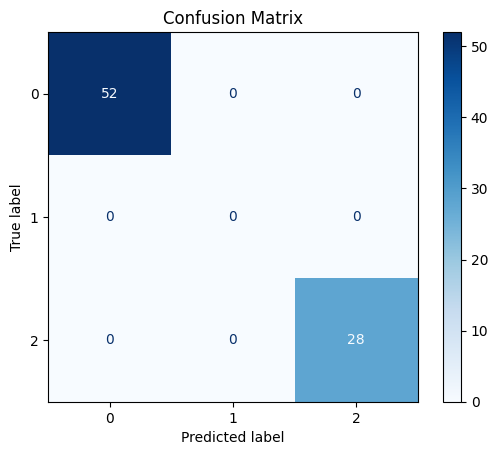

In [26]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


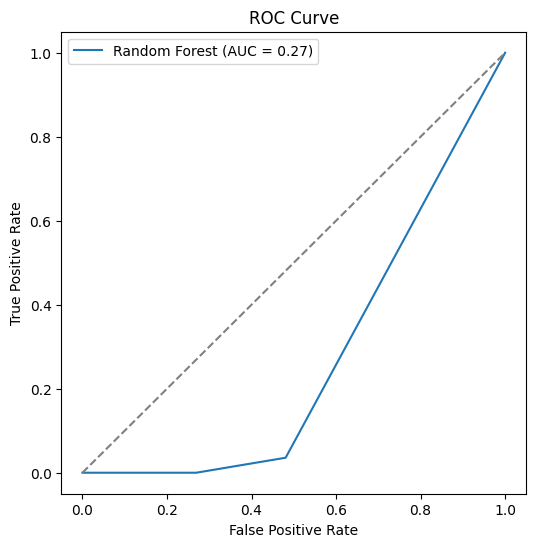

In [31]:

from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Remap: 2 -> 1
y_test_fixed = np.where(y_test == 2, 1, y_test)

# Get probabilities for ROC
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_fixed, y_prob, pos_label=1)
roc_auc = roc_auc_score(y_test_fixed, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
